In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

y_test = test_df.pop('Class')
x_test = test_df
y_train = train_df.pop('Class')
x_train = train_df
y_val = val_df.pop('Class')
x_val = val_df

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [25]:
import tensorflow as tf
from tensorflow import keras
hln = 512
BATCH_SIZE=200
EPOCHS=100
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
model = tf.keras.Sequential([
    keras.layers.Dense(hln, activation='relu',input_shape=(x_train.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(hln/2, activation='relu'),
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
    keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='categorical_accuracy',
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

baseline_history = model.fit(
    x_train,
    tf.one_hot(y_train, 3),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, tf.one_hot(y_val, depth=3)),
    callbacks=[early_stopping])


Epoch 1/100


ValueError: in user code:

    /home/andrew/.local/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/andrew/.local/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/andrew/.local/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /home/andrew/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/andrew/.local/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /home/andrew/.local/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/andrew/.local/lib/python3.8/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/andrew/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 210, 3) are incompatible


0.9391263723373413


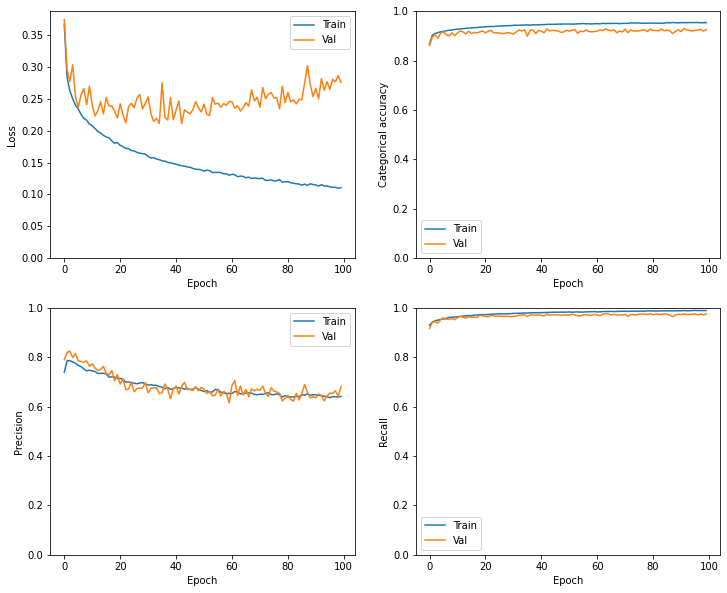

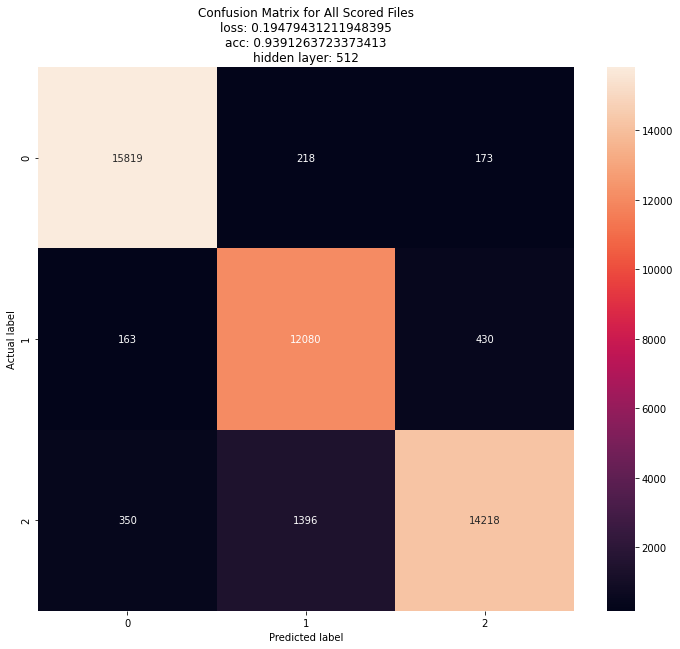

In [12]:
from scripts.utils import *
plt.rcParams["figure.facecolor"] = 'w'
plot_metrics(baseline_history,"",hln)
train_predictions_baseline = model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(x_test, tf.one_hot(y_test,depth=3),
                                    batch_size=BATCH_SIZE, verbose=0)
print(baseline_results[1])
plot_cm(tf.one_hot(y_test,depth=3).numpy().argmax(axis=1),test_predictions_baseline.argmax(axis=1),baseline_results,hln,"All Scored Files")
date = strftime('%X %x').replace("/","").split()
plt.savefig("figures/"+str(date[1])+"@"+str(date[0][:5].replace(":",""))+"_"+str(hln)+"neurons_confusion_matrix.png",bbox_inches='tight',transparent=False)